#  Прогнозирование заказов такси

## Описание проекта

Компания «Желтое такси» собрала исторические данные о заказах такси в аэропортах. Для того чтобы привлечь больше водителей в период пиковой нагрузки, необходимо предсказать количество заказов такси на следующий час. Нужно простроить модель предсказания временных рядов.
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48 (кол-во заказов).

## Описание данных

*Для повторения проекта, можно использовать открытый датасет `taxi.csv` с сайта [kaggle.com](https://www.kaggle.com/c/yellowtaxi/data).*

- `index` - дата и время заказа
- `num_orders` - количество заказов

## Подготовка и анализ

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from catboost import CatBoostRegressor

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков нет, типы данных корректны. Посмотрим на монотонность индекса.

In [4]:
df.index.is_monotonic_increasing

True

In [5]:
df.sort_index(inplace=True)

Индекс монотонно возрастает. Сделаем ресемплирование по одному часу.

In [6]:
# resample data to 1 hour
df = df.resample('1H').sum()

Еще раз посмотрим на данные.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Все данные корректны. Пропусков нет. Продолжим анализ.

In [8]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Данные распределены нормально, но есть выбросы. Посмотрим на число заказов в зависимости от времени.

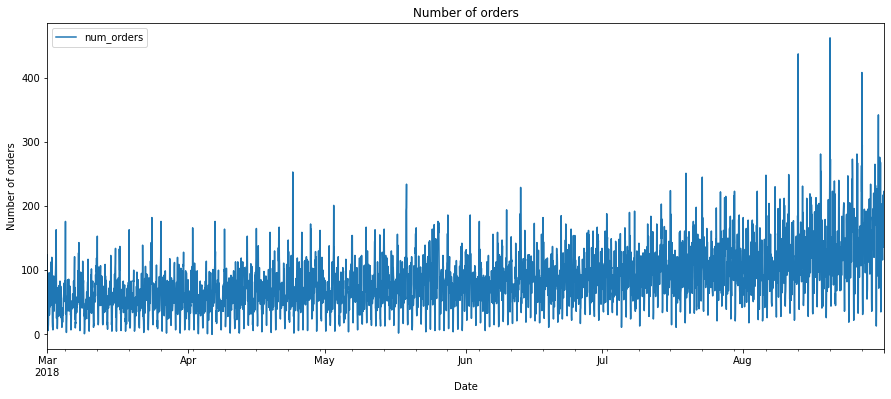

In [9]:
# plot data and add title and labels
df.plot(figsize=(15, 6), title='Number of orders')
plt.xlabel('Date')
plt.ylabel('Number of orders')
plt.show()

Такие данные сложно анализировать. Посмотрим на них в другом виде.

Создаем датафрейм для анализа. Так как, мы предсказываем спрос на следующий час, то будем анализировать данные за последний два дня. А Тренд и остатки будем анализировать за весь период.

In [10]:
# create df for analysis
df_analysis_day = df.copy()[['num_orders']]['2018-08-01':'2018-08-02']
df_analysis = df.copy()[['num_orders']]['2018-07-01':'2018-08-31']

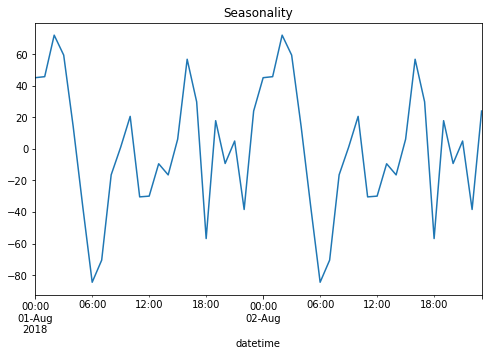

In [11]:
# analyze data seasonal
decomposed = seasonal_decompose(df_analysis_day)

plt.figure(figsize=(8, 5))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.show()

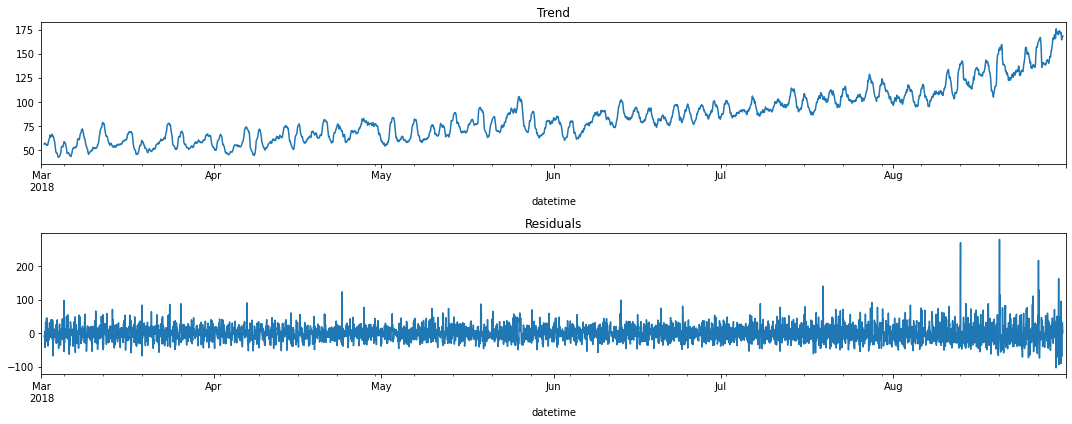

In [12]:
# analyze data trend and residuals
decomposed = seasonal_decompose(df)

plt.figure(figsize=(15, 6))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(212)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()


На графике тренда видно, что число заказов каждый день растет, но присутствуют падения. График сезонности, является стационарным, т.е. не меняется со временем. Это хороший знак, т.к. это значит, что на данных можно делать предсказание. График остатков показывает, что остатки не имеют тренда и сезонности. Наблюдаются заметные выбросы и примерно одинаковый уровень шума с плавным увеличением. Посмотрим на график автокорреляции и частичной автокорреляции.

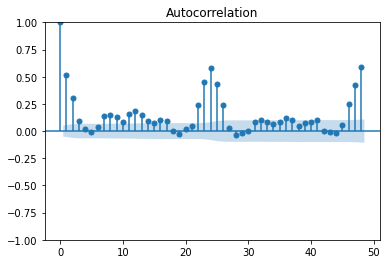

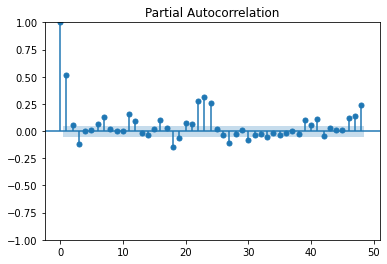

In [13]:
# plot autocorrelation and partial autocorrelation
sm.graphics.tsa.plot_acf(df_analysis.values.squeeze(), lags=48)
sm.graphics.tsa.plot_pacf(df_analysis.values.squeeze(), lags=48)
plt.show()

На графике автокорреляции и частичной автокорреляции видно, что данные имеют суточную сезонность и закономерность. Пресутсвуют не значительные выбросы. Посмотрим на график скользящего среднего и стандартного отклонения.

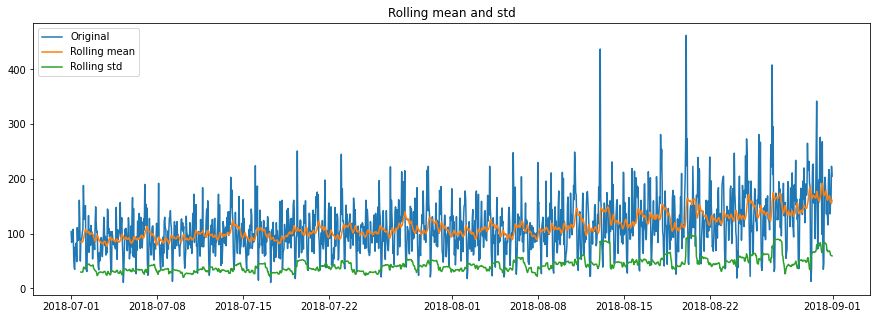

In [14]:
# plot rolling mean and std
plt.figure(figsize=(15, 5))
plt.plot(df_analysis.index, df_analysis['num_orders'], label='Original')
plt.plot(df_analysis.index, df_analysis['num_orders'].rolling(20).mean(), label='Rolling mean')
plt.plot(df_analysis.index, df_analysis['num_orders'].rolling(20).std(), label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling mean and std')
plt.show()

На графике мы можем наблюдать, что стандартное отклонение растет со временем. Это говорит о том, что данные становятся менее стационарными со временем. Так же присутствуют выбросы. Среднее значение растет со временем.

<AxesSubplot:xlabel='datetime'>

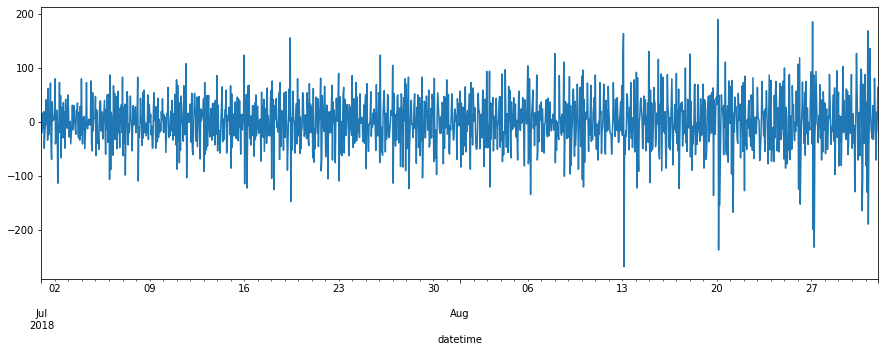

In [15]:
# plot differenced data
df_analysis['diff1'] = df_analysis['num_orders'] - df_analysis['num_orders'].shift(1)
df_analysis['diff1'].plot(figsize=(15, 5))

На графике разностей видно, что данные стали более стационарными. Посмотрим на сезонность, тренд и шумы для разности.

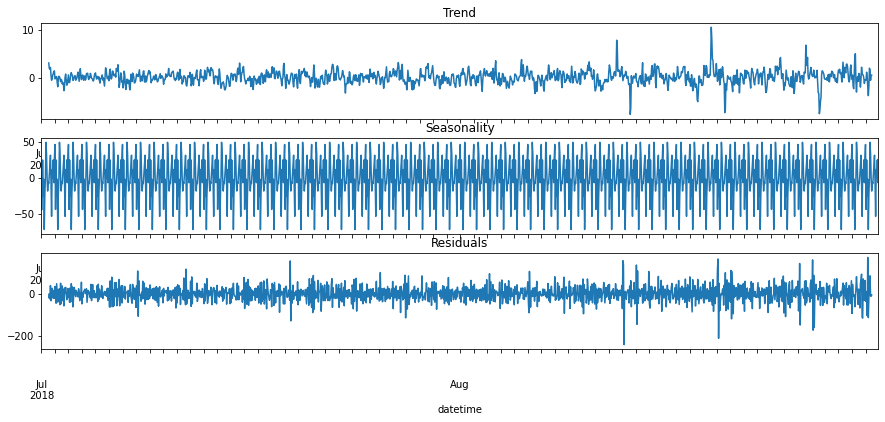

In [16]:
# analyze differenced data seasonal_decompose. Show xticks for 1 day
decomposed = seasonal_decompose(df_analysis['diff1'][1:])
plt.figure(figsize=(15, 6))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), xticks=df_analysis.index[::24])
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), xticks=df_analysis.index[::24])
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), xticks=df_analysis.index[::24])
plt.title('Residuals')

plt.show()

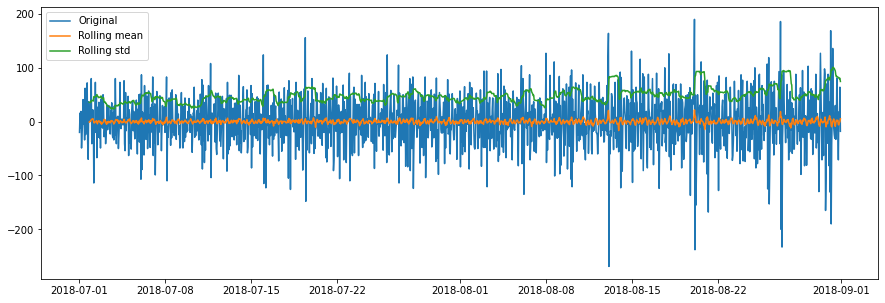

In [17]:
# plot rolling mean and std
plt.figure(figsize=(15, 5))
plt.plot(df_analysis.index, df_analysis['diff1'], label='Original')
plt.plot(df_analysis.index, df_analysis['diff1'].rolling(20).mean(), label='Rolling mean')
plt.plot(df_analysis.index, df_analysis['diff1'].rolling(20).std(), label='Rolling std')
plt.legend(loc='best')

## Подготовка данных

Создадим функцию для создания новых признаков.

In [18]:
# create new features for time series
def make_features(data, max_lag, rolling_size):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()

    data['day'] = data.index.day
    data['hour'] = data.index.hour

    data.dropna(inplace=True)

In [19]:
# create new features
make_features(df, 168, 48)

Разделим данные на тренировочную, валидационную и тестовую выборки. В соотношении test 10% | train 90%.

In [20]:
# split data into train, val and test sets in train-90% test-10% ratio with random shuffle
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Проверим размеры и даты каждого набора.

In [21]:
# check the size of each set
(train.shape, test.shape)

((3823, 172), (425, 172))

In [22]:
# check the start and end dates of each set
(train.index.min(), train.index.max()), (test.index.min(), test.index.max())

((Timestamp('2018-03-08 00:00:00', freq='H'),
  Timestamp('2018-08-14 06:00:00', freq='H')),
 (Timestamp('2018-08-14 07:00:00', freq='H'),
  Timestamp('2018-08-31 23:00:00', freq='H')))

Данный разделены правильно. Теперь разделим каждый набор на признаки и целевой признак.

In [23]:
# split data into features and target
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## Обучение моделей

In [24]:
# set random seed
random_seed = 42

Обучим модели и посмотрим на их качество.

In [25]:
# train LinearRegression using cross-validation with 5 folds for time series.
lr = LinearRegression()

cv = TimeSeriesSplit(n_splits=5)
cv_scores_lr = cross_val_score(lr, features_train, target_train, cv=cv, scoring='neg_mean_squared_error')

lr.fit(features_train, target_train)

print('RMSE for LinearRegression: {:.2f}'.format(np.sqrt(-cv_scores_lr.mean())))

RMSE for LinearRegression: 22.88


In [26]:
# train CatBoostRegressor model. Search best params and make cross-validation with 5 folds for time series. Show RMSE
cb = CatBoostRegressor(random_state=random_seed, verbose=0)

params = {'depth': range(1, 11),
          'learning_rate': np.arange(0.01, 0.3, 0.05),
          'iterations': range(10, 101, 10),
          }

cb_random = RandomizedSearchCV(cb, params, cv=TimeSeriesSplit(n_splits=5), n_iter=5, random_state=random_seed, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
cb_random.fit(features_train, target_train)

print('Best params for CatBoostRegressor is {}'.format(cb_random.best_params_))
print('Best RMSE for CatBoostRegressor is {:.2f}'.format(-cb_random.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params for CatBoostRegressor is {'learning_rate': 0.21000000000000002, 'iterations': 80, 'depth': 2}
Best RMSE for CatBoostRegressor is 22.79


Мы обучили две модели. Линейная регрессия показала RMSE 22.88, а CatBoostRegressor RMSE 22.79. Модели одинаково хорошо предсказывают целевой признак. Но CatBoostRegressor обучается дольше, чем линейная регрессия. Поэтому стоит остановиться на линейной регрессии. Перейдем к проверке моделей на тестовой выборке.

## Тестирование

Что проверить модели на адекватность обучим константную модель и посмотрим на его RMSE.

In [27]:
# make constant model for time series and show RMSE for test set
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

print('RMSE for constant model is {:.2f}'.format(mean_squared_error(target_test, pred_previous, squared=False)))

RMSE for constant model is 58.82


In [28]:
# test LinearRegression model and show RMSE for test set
predictions = lr.predict(features_test)
print('RMSE for LinearRegression is {:.2f}'.format(mean_squared_error(target_test, predictions, squared=False)))

RMSE for LinearRegression is 34.21


In [29]:
# test catboost model and show RMSE for test set
predictions = cb_random.predict(features_test)

print('RMSE for CatBoostRegressor is {:.2f}'.format(mean_squared_error(target_test, predictions, squared=False)))

RMSE for CatBoostRegressor is 38.87


## Создание пайплайна

In [ ]:
# create pipeline for time series with LinearRegression and make feature function
pipe = Pipeline([('make_features', FunctionTransformer(make_features, kw_args={'max_lag': 168, 'rolling_size': 48})),
                 ('lr', LinearRegression())])

In [ ]:
# train pipeline
pipe.fit(features_train, target_train)

In [ ]:
# save pipeline
with open('pipe.pkl', 'wb') as f:
    pickle.dump(pipe, f)

## Выводы

В ходе работы были выполнены следующие шаги:

- Мы провели анализ данных и обучили модели для предсказания количества заказов такси.
- Было обучено две модели: линейная регрессия и CatBoostRegressor. Модели одинаково хорошо предсказывают целевой признак. Но CatBoostRegressor обучается дольше, чем линейная регрессия. Поэтому стоит остановиться на линейной регрессии.
- Помимо этого, мы проверили данные на адекватность обучив DummyRegressor и посмотрели на его RMSE. Мы получили RMSE 58.82, что больше, чем RMSE обученных моделей. Это значит, что предсказание адекватное.
- Еще, проверка моделей показала, что линейная регрессия немного переобучена, но это не сильно влияет на качество модели (RMSE 34.22). Модель CatBoostRegressor тоже показала хороший результат (RMSE 38.87). Но линейная регрессия обучается быстрее и меньше подвержена переобучению.
- Также мы создали пайплайн для обучения модели. Пайплайн состоит из функции для создания признаков и модели линейной регрессии.